In [15]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pyFlame.config import Config
from pyFlame.flame_solver import FlameSolver
from pyFlame.strain import ConstantStrain, OscillatingStrain, RampedStrain
from pyFlame.integrators import IntegratorType, IntegratorAPI
from pyFlame.utils.plot import *

In [2]:
# Create configuration
config = Config(
    # Chemistry setup
    mechanism="gri30.yaml",
    fuel="CH4",
    oxidizer="O2:1.0, N2:3.76",
    phi=1.0,  # Stoichiometric
    
    # Domain setup
    x_min=-0.02,  # 2
    x_max=0.02,  # 2 cm domain
    grid_points=200,
    dt_min = 1e-6,
    dt_max = 1e-4,
    # Flame configuration
    flame_type="diffusion",  # Diffusion flame
    T_fuel=600.0,        # Cold fuel
    T_oxidizer=1200.0,   # Hot oxidizer - high enough to ensure ignition
    pressure=101325.0,  # 1 atm
    fuel_left=True,  # Fuel on the left
    
    # Solver settings
    dt=1e-6,  # Initial timestep
    t_start=0.0,
    t_end=0.01,  # Run for 0.1 seconds
    rel_tol=1e-6,
    abs_tol=1e-8,
    
    # Grid adaptation
    adaptation_interval=5000,
    grad_tol=0.2,
    curv_tol=0.02,
    flame_res=0.1,
    
    # strain rate
    strain_function=ConstantStrain(20),  # 10 1/s strain rate
    
    default_integrator = "BDF",
    integrator_api = IntegratorAPI.SOLVE_IVP,
    
    use_mixing_layer=True,
    mixing_width=0.002,  # 2mm mixing layer
    use_ignition_zone=False,
    ignition_width=0.001,  # 1mm ignition zone
    ignition_T_peak=1800,   # +300K temperature peak
    
    use_cantera=False,
    use_parallel=False,
    
    save_interval=10,
)

In [3]:
# Create solver
solver = FlameSolver(config)

In [4]:
solver.initialize_solution()

In [5]:
gas = solver.gas
names = gas.species_names
ch4_index = names.index('CH4')
o2_index = names.index('O2')
n2_index = names.index('N2')
h2o_index = names.index('H2O')
co2_index = names.index('CO2')
co_index = names.index('CO')
oh_index = names.index('OH')


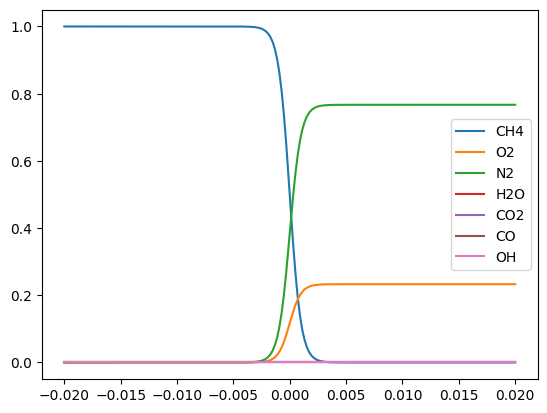

In [6]:
# plt.plot(solver.grid.x, solver.flame_state.T)
# plt.show()

plt.plot(solver.grid.x, solver.flame_state.Y[ch4_index], label='CH4')
plt.plot(solver.grid.x, solver.flame_state.Y[o2_index], label='O2')

plt.plot(solver.grid.x, solver.flame_state.Y[n2_index], label='N2')

plt.plot(solver.grid.x, solver.flame_state.Y[h2o_index], label='H2O')

plt.plot(solver.grid.x, solver.flame_state.Y[co2_index], label='CO2')

plt.plot(solver.grid.x, solver.flame_state.Y[co_index], label='CO')

plt.plot(solver.grid.x, solver.flame_state.Y[oh_index], label='OH')

plt.legend()
plt.show()



In [7]:
# Solve
print("Solving flame...")
success = solver.solve()


Solving flame...
[INFO] - Grid already at minimum points


/Users/elotech/.virtualenvs/mlEnv/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/Users/elotech/.virtualenvs/mlEnv/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


t = 1.0000e-04 s - max T = 1200.00 K - dt = 2.00e-06 s - flame speed = 1.72e-03 m/s
Grid quality: {'min_dx': 0.00020100502512562443, 'max_dx': 0.00020100502512563484, 'mean_dx': 0.00020100502512562814, 'grid_points_in_flame': 199}
Conservation errors: {'mass_flux_error': -1.8991764118296013, 'species_sum_error': 2.220446049250313e-16}
{'total_heat_release': 46.38513473151849, 'peak_heat_release': 216078.0352675294, 'flame_thickness': 0.002193066597459624, 'max_temperature': 1200.0000279344254, 'max_temperature_gradient': 273589.5155347623, 'max_temperature_gradient_location': 0.00010050251256281395, 'mid_point_temperature': 927.8118951929722, 'H2O_mass_fraction at mid-point': 1.7763412594224564e-12}
t = 2.0000e-04 s - max T = 1200.00 K - dt = 2.00e-06 s - flame speed = 1.72e-03 m/s
Grid quality: {'min_dx': 0.00020100502512562443, 'max_dx': 0.00020100502512563484, 'mean_dx': 0.00020100502512562814, 'grid_points_in_flame': 199}
Conservation errors: {'mass_flux_error': -1.8991763981179715

In [9]:
data = {
            'times': np.array(solver.history.times, dtype=object),
            'T': np.array(solver.history.T, dtype=object),
            'U': np.array(solver.history.U, dtype=object),
            'Y': solver.history.Y,
            'x': np.array(solver.history.x, dtype=object),
            'rho': np.array(solver.history.rho, dtype=object),
            'cp': np.array(solver.history.cp, dtype=object),
            'heat_release': np.array(solver.history.heat_release, dtype=object)
        }

# save data as pickle
import pickle
with open('data_new.pkl', 'wb') as f:
    pickle.dump(data, f)

In [10]:
# get CH4 index
CH4_index = solver.gas.species_index(config.fuel)
O2_index = solver.gas.species_index("O2")

<Figure size 2400x2000 with 0 Axes>

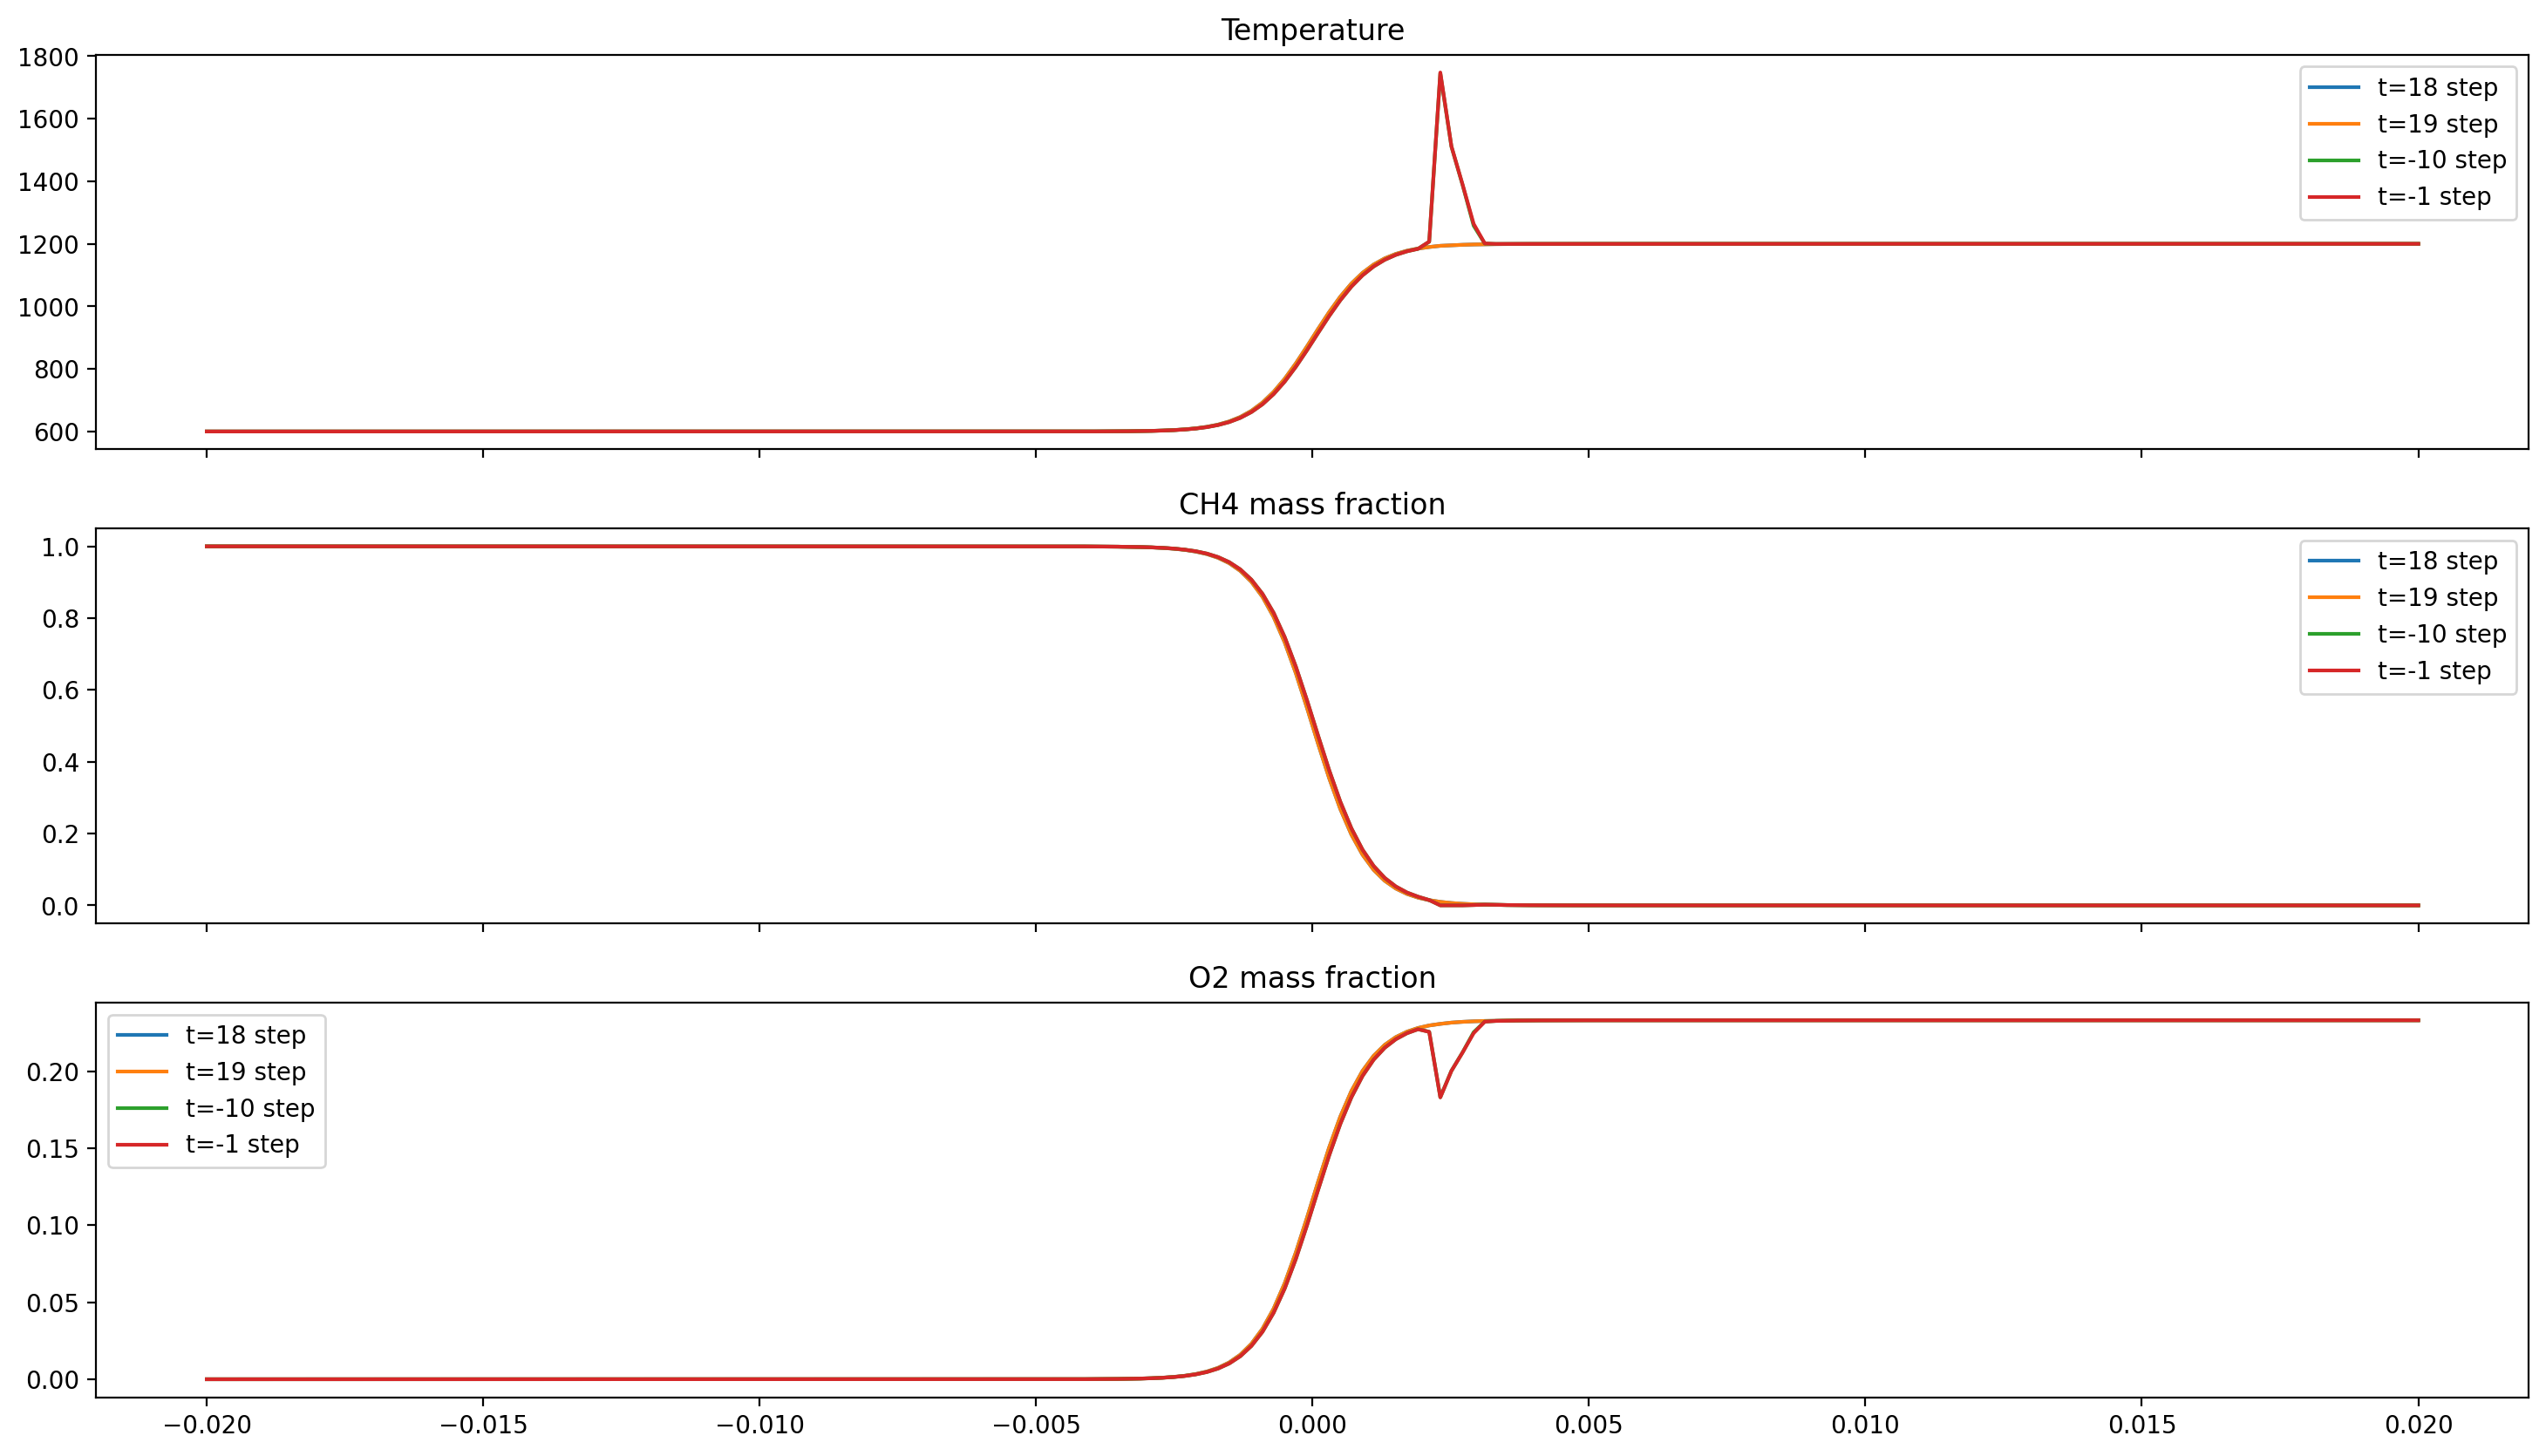

In [11]:
# plt.plot(solver.history.x[0], solver.history.T[0], label=f"t={0:.2e}")


fig = plt.figure(figsize=(12, 10), dpi=200)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18, 10), dpi=200)
ax1.plot(solver.history.x[18], solver.history.T[18], label=f"t={18} step")
ax1.plot(solver.history.x[19], solver.history.T[19], label=f"t={19} step")
ax1.plot(solver.history.x[-10], solver.history.T[-10], label=f"t={-10} step")
ax1.plot(solver.history.x[-1], solver.history.T[-1], label=f"t={-1} step")
ax1.legend()
ax1.title.set_text("Temperature")

ax2.plot(solver.history.x[18], solver.history.Y[18][CH4_index], label=f"t={18} step")
ax2.plot(solver.history.x[19], solver.history.Y[19][CH4_index], label=f"t={19} step")
ax2.plot(solver.history.x[-10], solver.history.Y[-10][CH4_index], label=f"t={-10} step")
ax2.plot(solver.history.x[-1], solver.history.Y[-1][CH4_index], label=f"t={-1} step")

ax3.plot(solver.history.x[18], solver.history.Y[18][O2_index], label=f"t={18} step")
ax3.plot(solver.history.x[19], solver.history.Y[19][O2_index], label=f"t={19} step")
ax3.plot(solver.history.x[-10], solver.history.Y[-10][O2_index], label=f"t={-10} step")
ax3.plot(solver.history.x[-1], solver.history.Y[-1][O2_index], label=f"t={-1} step")
ax3.legend()
ax3.title.set_text("O2 mass fraction")


ax2.title.set_text("CH4 mass fraction")

ax2.legend()
plt.show()

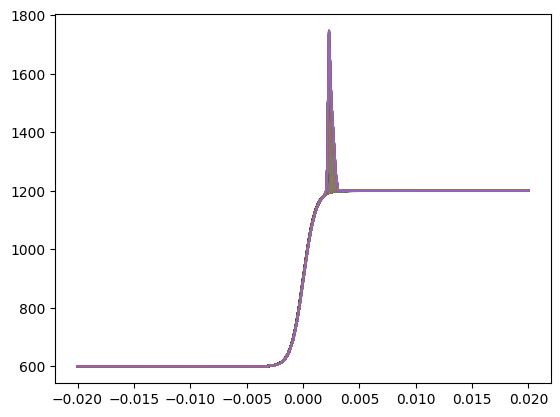

In [12]:
for i, ts in enumerate(solver.history.T):
    plt.plot(solver.history.x[i], solver.history.T[i], label=f"t={i:.2e}")

In [ ]:
def debug_chemistry(solver):
    # Get middle point
    j = solver.n_points//2
    print(f"Max reaction rate: {np.max(np.abs(solver.chemistry.wdot))}")
    print(f"Temperature: {solver.chemistry.state[solver.chemistry.i_T]}")
    
debug_chemistry(solver)

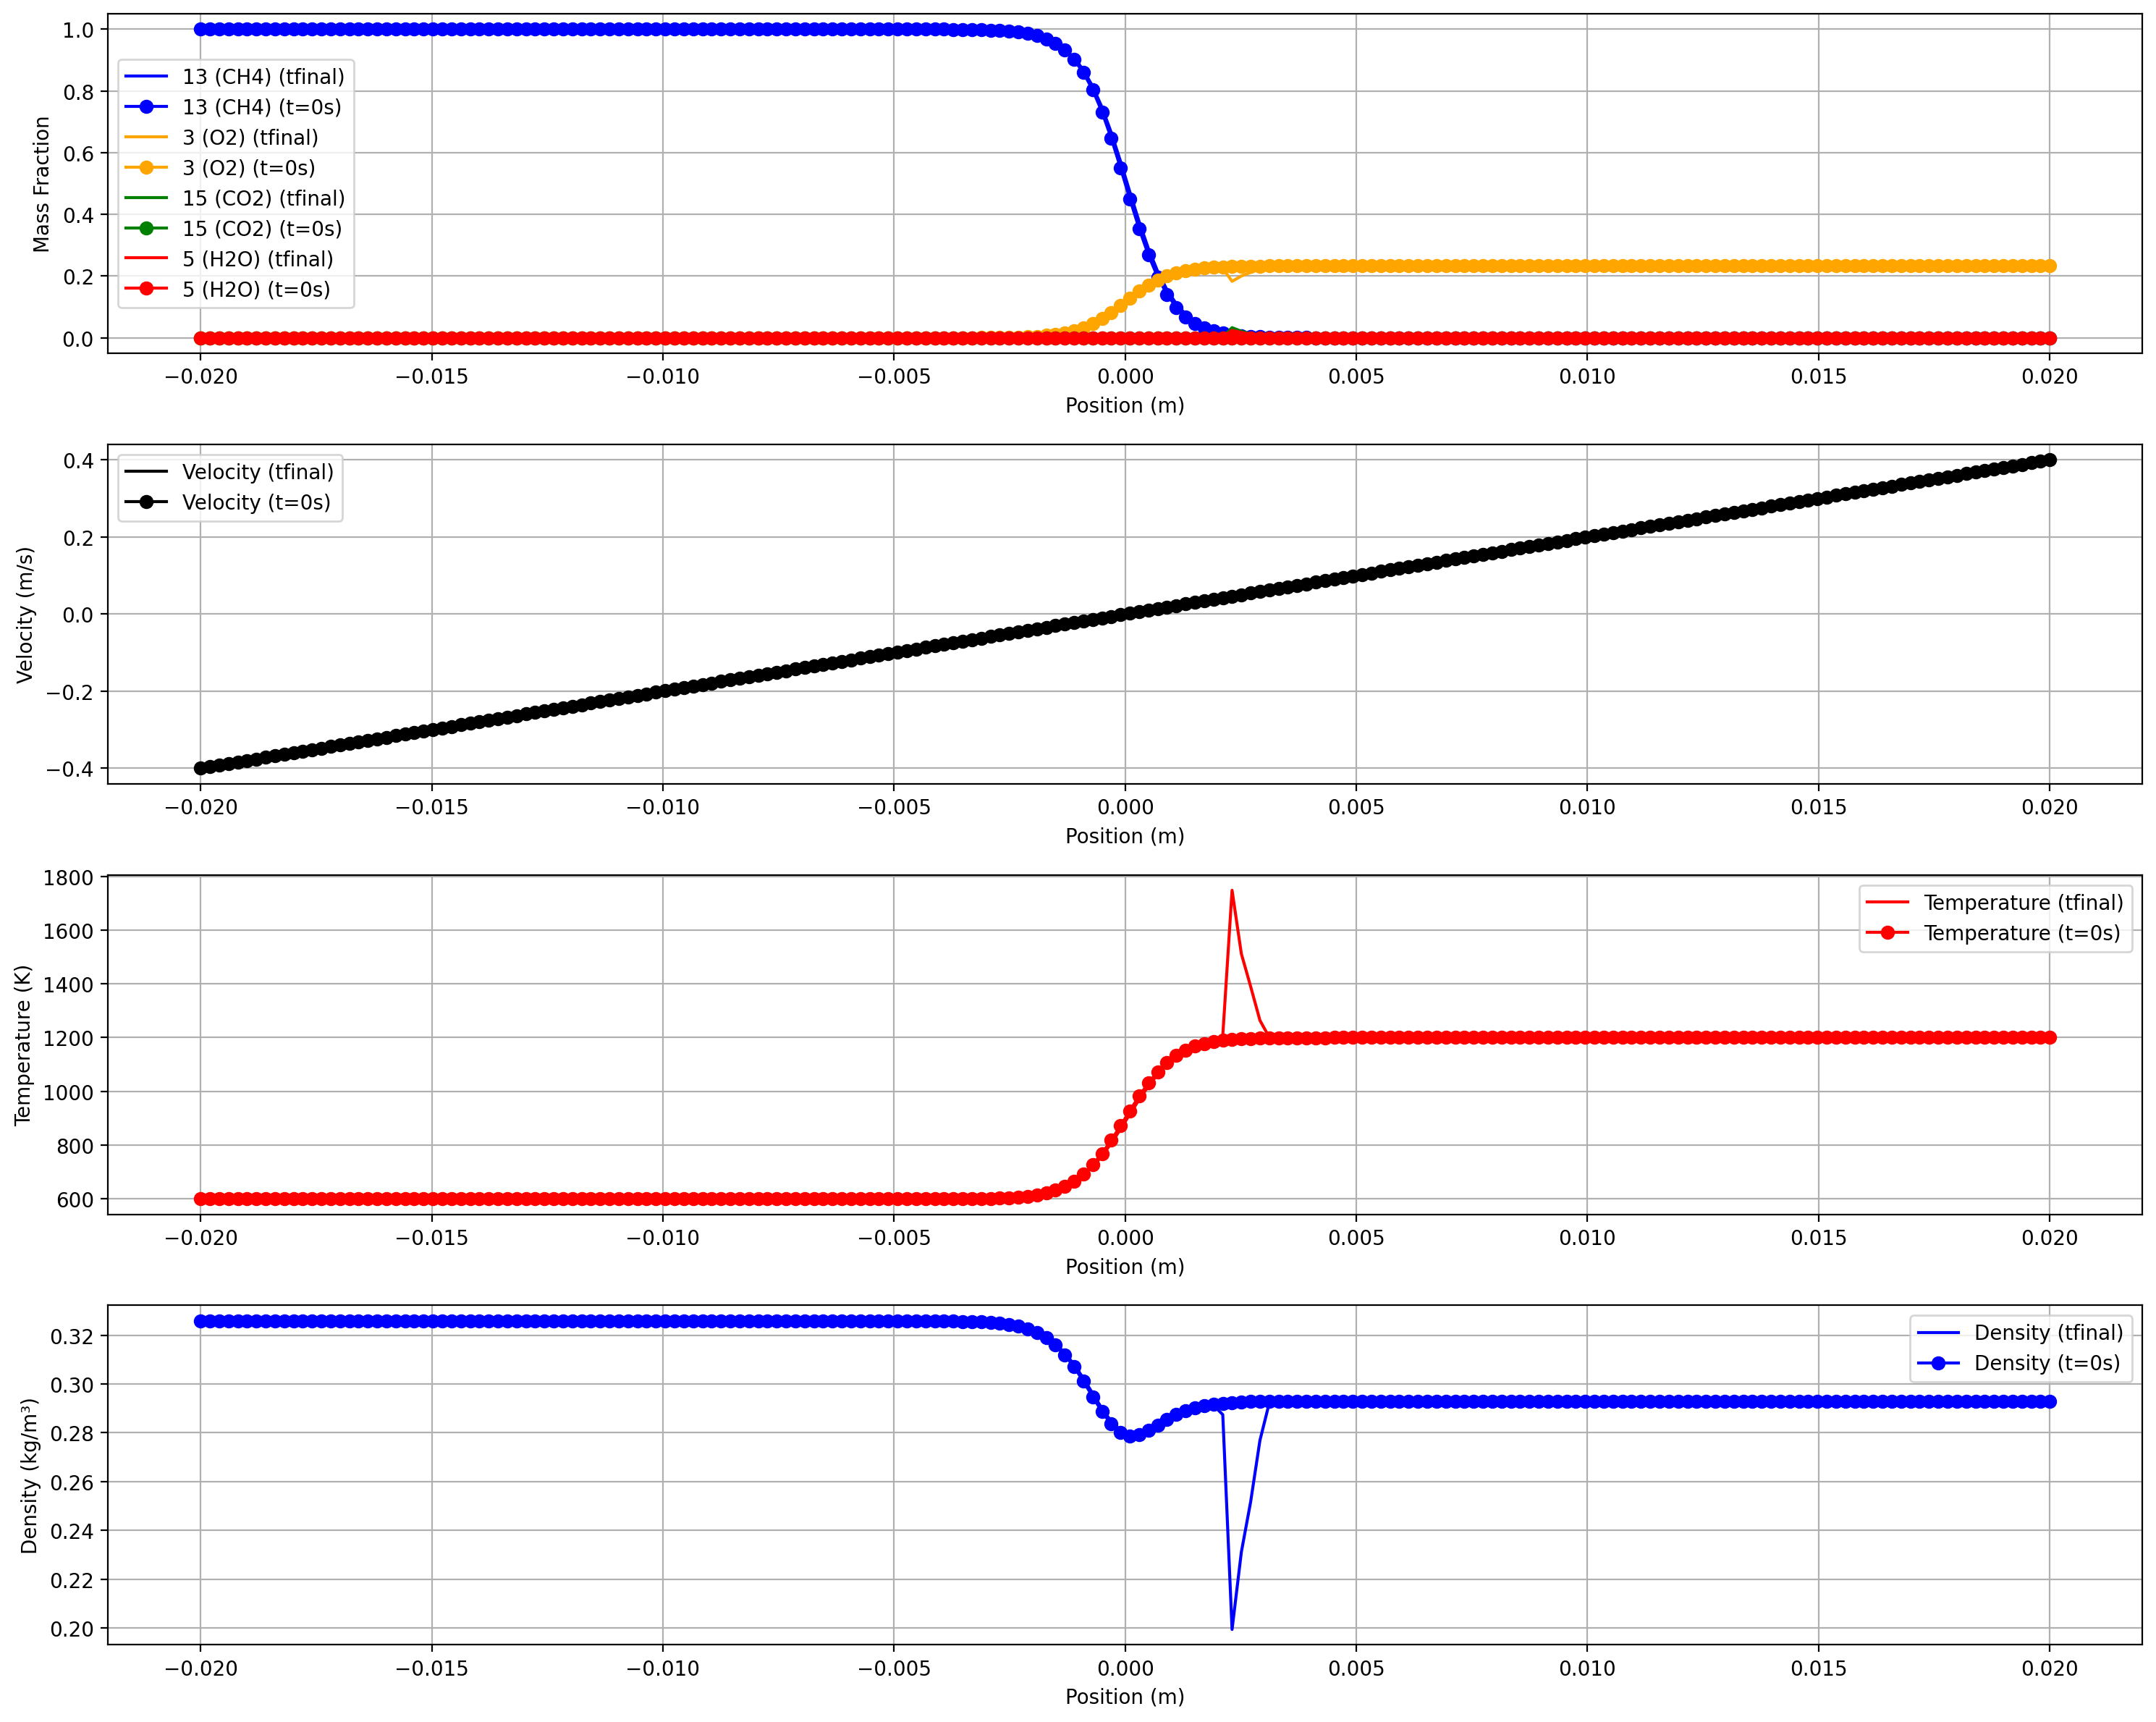

In [13]:
def plot_results__(solver, species_to_plot=None, save_path=None):
    """Plot initial and final states"""
    plt.figure(figsize=(6, 4), dpi=200)
    
    history = solver.history
    x_final = history.x[-1]
    
    # Plot species mass fractions
    plt.subplot(1, 1, 1)
    if species_to_plot is None:
        species_to_plot = [0, 1, 2]  # Default to first three species
    
    colors = ['b', 'orange', 'g', 'r']
    species_names = solver.gas.species_names
    for k, spec_name in enumerate(species_to_plot):
        # # Final state
        spec_idx = solver.gas.species_index(spec_name)
        # Y_final = history.Y[-1][spec_idx]
        # plt.plot(x_final, Y_final, color=colors[k], 
        #         label=f"{spec_idx} ({species_names[spec_idx]}) (tfinal)")
        
        # Initial state
        x_init = history.x[0]
        Y_init = history.Y[0][spec_idx]
        if len(x_init) != len(x_final):
            interp = interp1d(x_init, Y_init, kind='linear', 
                            bounds_error=False, fill_value='extrapolate')
            Y_init = interp(x_final)
            
        plt.plot(x_final, Y_init, color=colors[k], 
                label=f'{spec_idx} ({species_names[spec_idx]}) (t=0s)')
    
    plt.xlabel('Position (m)')
    plt.ylabel('Mass Fraction')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')    
        
    plt.show()
    
    # # Plot velocity
    # plt.subplot(4, 1, 2)
    # plt.plot(x_final, history.U[-1], 'k-', label='Velocity (tfinal)')
    
    # # Initial velocity
    # U_init = history.U[0]
    # x_init = history.x[0]
    # if len(x_init) != len(x_final):
    #     interp = interp1d(x_init, U_init, kind='linear', 
    #                     bounds_error=False, fill_value='extrapolate')
    #     U_init = interp(x_final)
    # plt.plot(x_final, U_init, '-o', color='k', label='Velocity (t=0s)')
    
    # plt.xlabel('Position (m)')
    # plt.ylabel('Velocity (m/s)')
    # plt.legend()
    # plt.grid(True)
    
    # # Plot temperature
    # plt.subplot(4, 1, 3)
    # plt.plot(x_final, history.T[-1], 'r-', label='Temperature (tfinal)')
    
    # # Initial temperature
    # T_init = history.T[0]
    # x_init = history.x[0]
    # if len(x_init) != len(x_final):
    #     interp = interp1d(x_init, T_init, kind='linear', 
    #                     bounds_error=False, fill_value='extrapolate')
    #     T_init = interp(x_final)
    # plt.plot(x_final, T_init, '-o', color='r', label='Temperature (t=0s)')
    
    # plt.xlabel('Position (m)')
    # plt.ylabel('Temperature (K)')
    # plt.legend()
    # plt.grid(True)
    
    # # Plot density
    # plt.subplot(4, 1, 4)
    # plt.plot(x_final, history.rho[-1], 'b-', label='Density (tfinal)')
    
    # # Initial density
    # rho_init = history.rho[0]
    # x_init = history.x[0]
    # if len(x_init) != len(x_final):
    #     interp = interp1d(x_init, rho_init, kind='linear', 
    #                     bounds_error=False, fill_value='extrapolate')
    #     rho_init = interp(x_final)
    # plt.plot(x_final, rho_init, '-o', color='b', label='Density (t=0s)')
    
    # plt.xlabel('Position (m)')
    # plt.ylabel('Density (kg/m³)')
    # plt.legend()
    # plt.grid(True)
    
    # plt.tight_layout()
    # if save_path:
    #     plt.savefig(save_path, dpi=300, bbox_inches='tight')
    # plt.show()
    
plot_results(solver, species_to_plot=["CH4", "O2", "CO2", "H2O"], save_path="flame_results.png")

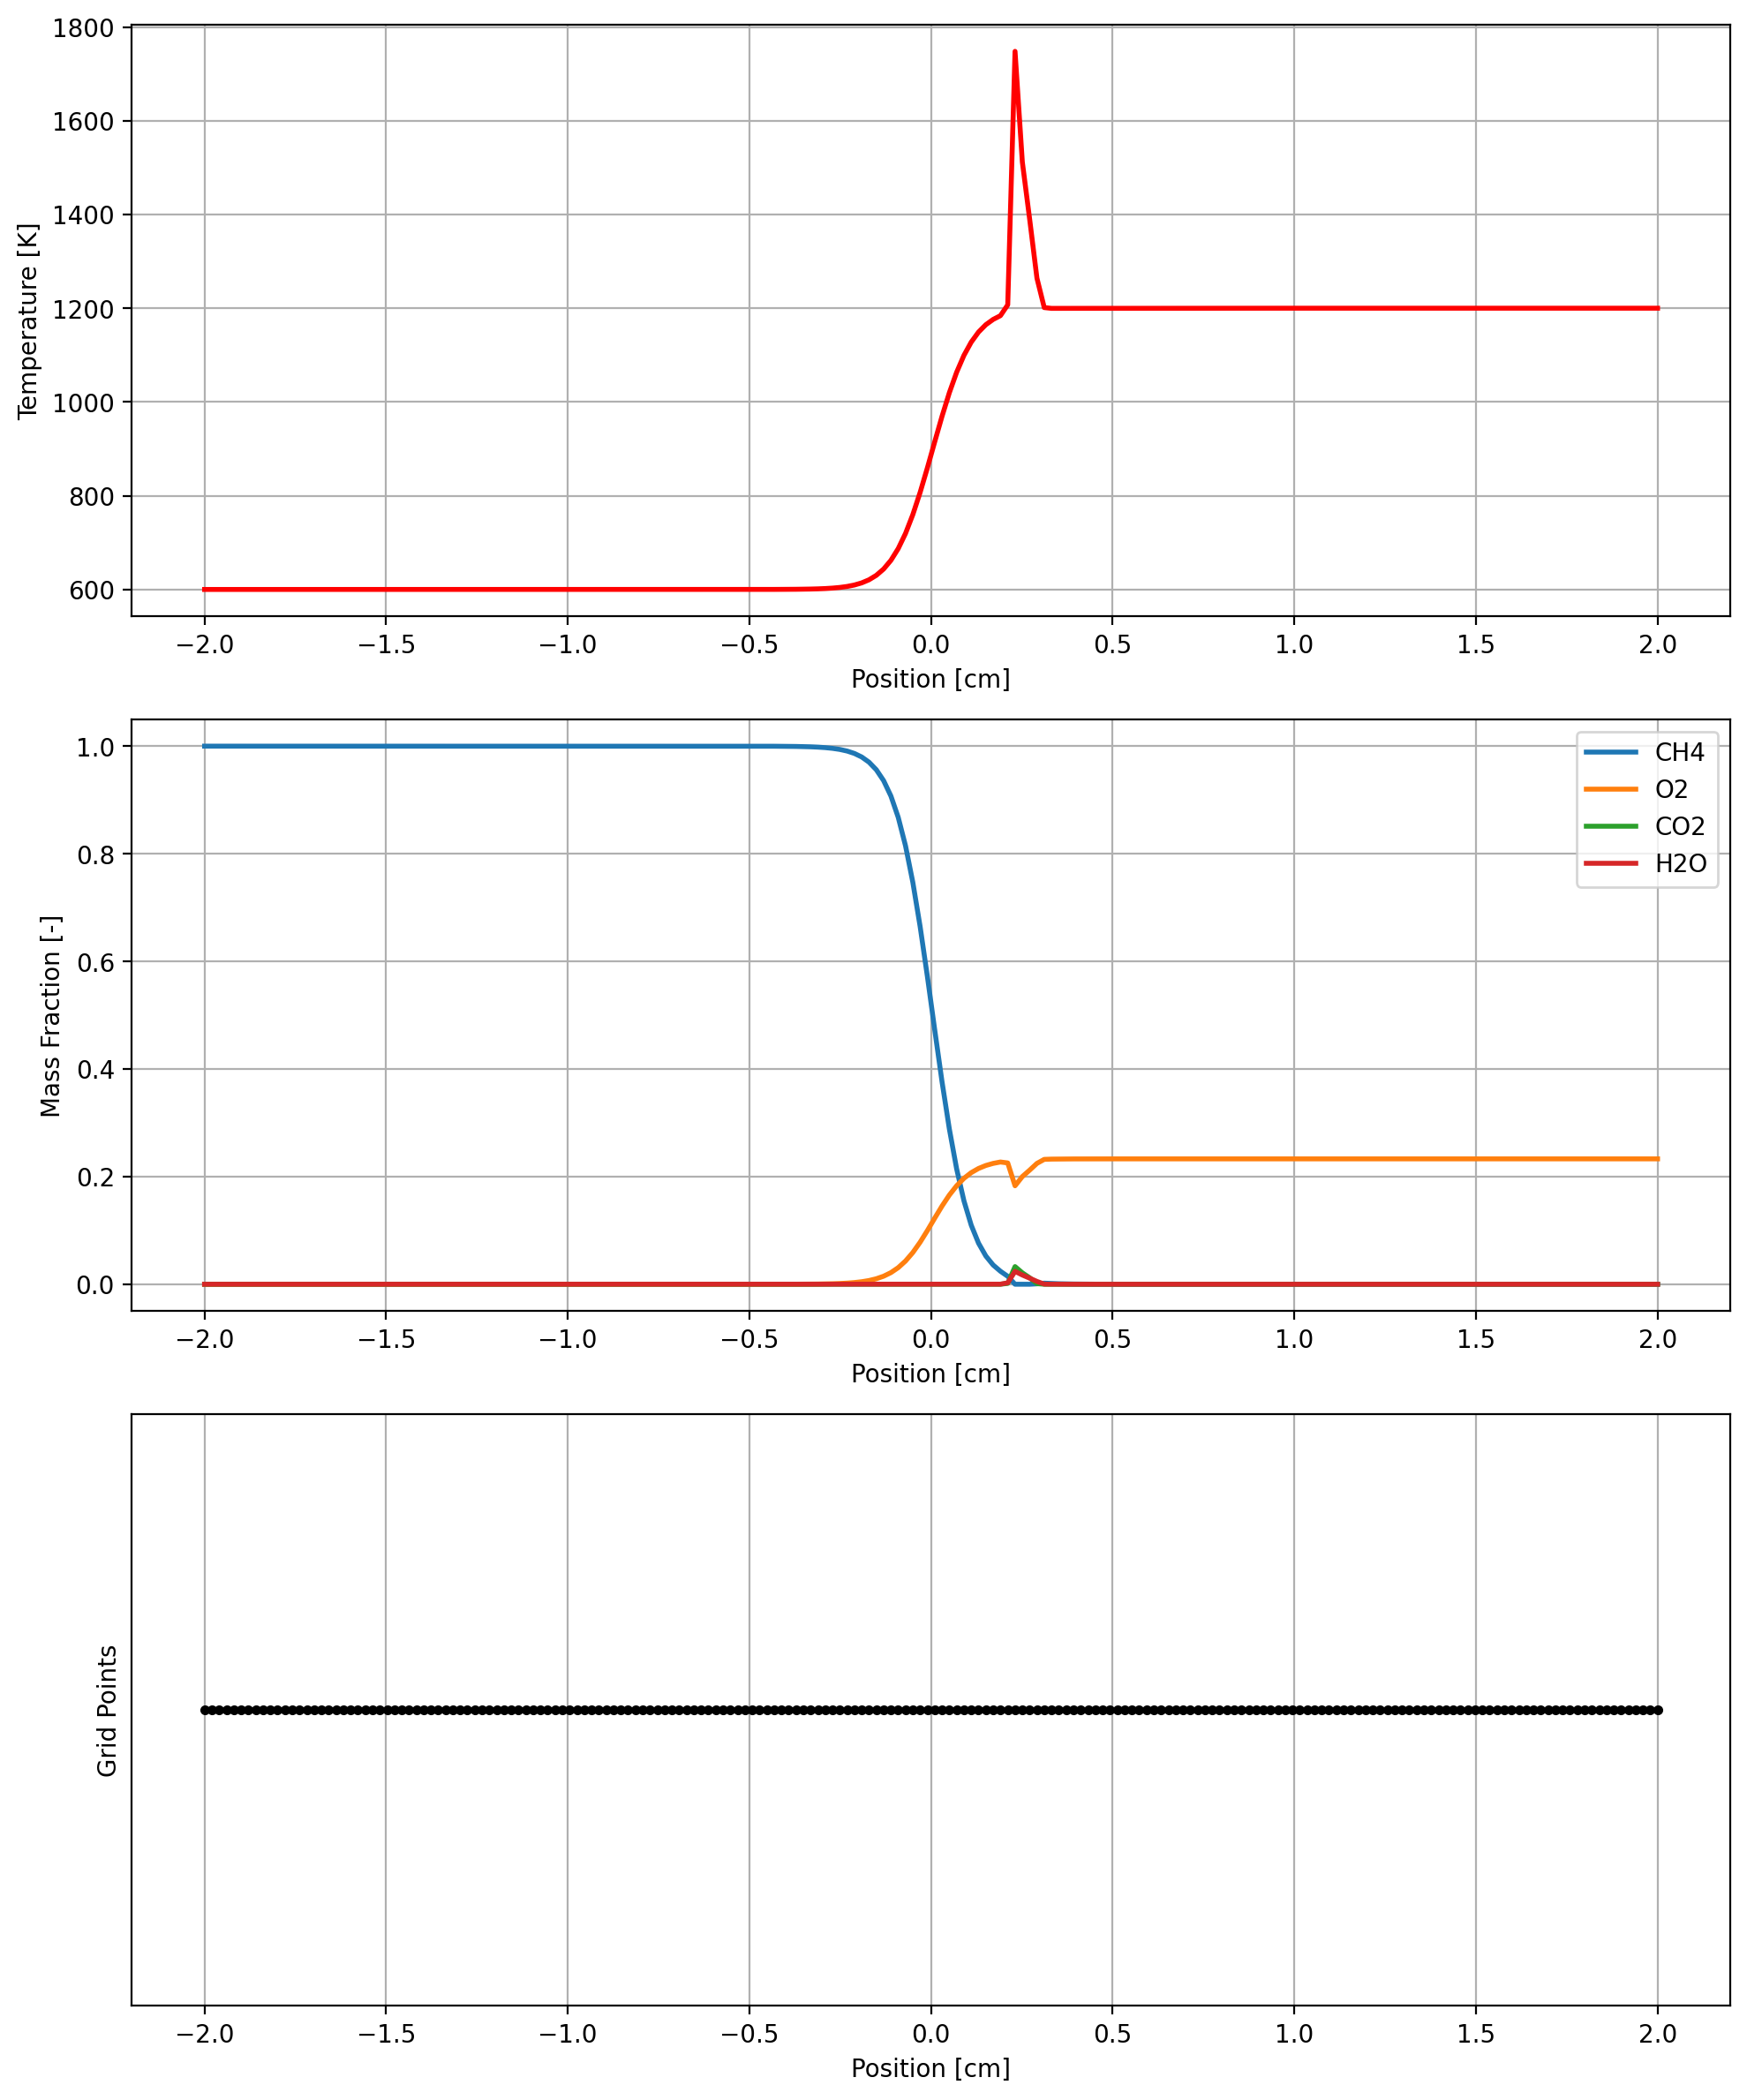


Simulation Statistics:
Final time: 1.000e-02 s
Number of grid points: 200
Number of grid adaptations: 0
Maximum temperature: 1748.0 K
Flame position: 0.21 cm


In [16]:
species_to_plot = ['H2O', 'CO2', 'CH4', 'O2']
# plot_results(solver, species_to_plot)
# plot_evolution(solver, species_to_plot)
plot_results_(solver)

In [ ]:
solver.calculate_flame_speed()

In [28]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import interp1d
import numpy as np

def animate_evolution(solver, species_to_plot=None, fps=30, duration=5, 
                     save_path=None, dpi=200, fig_size=(10, 8)):
    """
    Create an animation of the flame evolution.
    
    Args:
        solver: FlameSolver object containing the history
        species_to_plot: List of species names to plot (default: first two species)
        fps: Frames per second for the animation (default: 30)
        duration: Duration of the animation in seconds (default: 5)
        save_path: Path to save the animation (default: None)
        dpi: DPI for the figure (default: 200)
        fig_size: Figure size in inches (default: (10, 8))
    
    Returns:
        matplotlib.animation.Animation object
    """
    history = solver.history
    
    # Calculate number of frames and time points
    n_frames = int(fps * duration)
    time_indices = np.linspace(0, len(history.times)-1, n_frames).astype(int)
    
    # Create reference grid (use final grid points)
    x_ref = history.x[-1]
    
    # Setup the figure
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    plt.suptitle('Flame Evolution', fontsize=16, y=0.95)
    
    # Initialize subplots
    ax_species = plt.subplot(3, 1, 1)
    ax_temp = plt.subplot(3, 1, 2)
    ax_density = plt.subplot(3, 1, 3)
    
    # Setup species plot
    if species_to_plot is None:
        species_to_plot = solver.gas.species_names[:2]
    
    species_lines = []
    colors = plt.cm.tab10(np.linspace(0, 1, len(species_to_plot)))
    
    for spec_name, color in zip(species_to_plot, colors):
        spec_idx = solver.gas.species_index(spec_name)
        line, = ax_species.plot([], [], '-', color=color, label=f'{spec_name}')
        species_lines.append((line, spec_idx))
    
    ax_species.set_xlabel('Position (m)')
    ax_species.set_ylabel('Mass Fraction')
    ax_species.legend()
    ax_species.grid(True)
    
    # Setup temperature plot
    temp_line, = ax_temp.plot([], [], 'r-', label='Temperature')
    ax_temp.set_xlabel('Position (m)')
    ax_temp.set_ylabel('Temperature (K)')
    ax_temp.grid(True)
    ax_temp.legend()
    
    # Setup density plot
    density_line, = ax_density.plot([], [], 'b-', label='Density')
    ax_density.set_xlabel('Position (m)')
    ax_density.set_ylabel('Density (kg/m³)')
    ax_density.grid(True)
    ax_density.legend()
    
    # Add timestamp text
    time_text = plt.figtext(0.5, 0.91, '', ha='center', fontsize=12)
    
    # Set axis limits using all data
    def get_interpolated_data(data_list, x_list):
        all_data = []
        for data, x in zip(data_list, x_list):
            if len(x) != len(x_ref):
                interp = interp1d(x, data, kind='linear', bounds_error=False, 
                                fill_value='extrapolate')
                all_data.append(interp(x_ref))
            else:
                all_data.append(data)
        return np.array(all_data)
    
    # Set axis limits
    ax_species.set_xlim(min(x_ref), max(x_ref))
    ax_temp.set_xlim(min(x_ref), max(x_ref))
    ax_density.set_xlim(min(x_ref), max(x_ref))
    
    # # Y-limits for species
    # for spec_name in species_to_plot:
    #     spec_idx = solver.gas.species_index(spec_name)
    #     Y_data = [Y[spec_idx] for Y in history.Y]
    #     Y_interp = get_interpolated_data(Y_data, history.x)
    ax_species.set_ylim(0, 1.1)
    
    # Y-limits for temperature and density
    T_interp = get_interpolated_data(history.T, history.x)
    rho_interp = get_interpolated_data(history.rho, history.x)
    
    ax_temp.set_ylim(min(T_interp.min() * 0.9, 300), T_interp.max() * 1.1)
    ax_density.set_ylim(rho_interp.min() * 0.9, rho_interp.max() * 1.1)
    
    def update(frame):
        idx = time_indices[frame]
        current_time = history.times[idx]
        time_text.set_text(f'Time: {current_time*1000:.2f} ms')
        
        artists = []
        
        # Update species lines
        for line, spec_idx in species_lines:
            if len(history.x[idx]) != len(x_ref):
                interp = interp1d(history.x[idx], history.Y[idx][spec_idx], 
                                kind='linear', bounds_error=False, 
                                fill_value='extrapolate')
                y_plot = interp(x_ref)
            else:
                y_plot = history.Y[idx][spec_idx]
            line.set_data(x_ref, y_plot)
            artists.append(line)
        
        # Update temperature line
        if len(history.x[idx]) != len(x_ref):
            interp = interp1d(history.x[idx], history.T[idx], 
                            kind='linear', bounds_error=False, 
                            fill_value='extrapolate')
            T_plot = interp(x_ref)
        else:
            T_plot = history.T[idx]
        temp_line.set_data(x_ref, T_plot)
        artists.append(temp_line)
        
        # Update density line
        if len(history.x[idx]) != len(x_ref):
            interp = interp1d(history.x[idx], history.rho[idx], 
                            kind='linear', bounds_error=False, 
                            fill_value='extrapolate')
            rho_plot = interp(x_ref)
        else:
            rho_plot = history.rho[idx]
        density_line.set_data(x_ref, rho_plot)
        artists.append(density_line)
        
        artists.append(time_text)
        return artists
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, update, frames=n_frames, 
        interval=1000/fps,  # interval in milliseconds
        blit=True
    )
    
    if save_path:
        writer = animation.FFMpegWriter(fps=fps, bitrate=2000)
        anim.save(save_path, writer=writer)
    
    return anim

In [ ]:
anim = animate_evolution(solver, species_to_plot=species_to_plot, save_path="diffusion_flame_evolution.mp4", fps=5, duration=30)